In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
pd.set_option('display.max_columns', None)
from IPython.display import display
import lightgbm as lgb
import numpy as np


data = pd.read_csv("preprocessed_data.csv")
data.head()

,Unnamed: 0,title,link,description,garage,price,home_type,city,home_size,home_area,floor,elevator,price_per_sqr_meter,date,neighborhood,price_per_sqr_meter_bin,price_bin,home_area_bin,street_names
0,0,apartamento t0 em sao joao da caparica costa d...,https://www.idealista.pt/imovel/33182313/,"Apartamento T0, com vista de Mar.\nNão perca a...",False,1250,apartamento,almada,t0,60,10,True,20.833333,13-05-2024,costa de caparica,"(20.64, 24.61]","(355.38, 1364.8]","(42.28, 70.56]",sao joao da caparica costa de caparica
1,1,apartamento t0 em sao joao da caparica costa d...,https://www.idealista.pt/imovel/33225472/,Não perca a oportunidade de viver num apartame...,False,1200,apartamento,almada,t0,57,6,True,21.052632,13-05-2024,costa de caparica,"(20.64, 24.61]","(355.38, 1364.8]","(42.28, 70.56]",sao joao da caparica costa de caparica
2,2,apartamento t0 na avenida da liberdade 5 capar...,https://www.idealista.pt/imovel/33132721/,"Excelente apartamento t1 na Trafaria, a 2 minu...",False,1200,apartamento,almada,t0,50,1,False,24.000000,13-05-2024,almada,"(20.64, 24.61]","(355.38, 1364.8]","(42.28, 70.56]",avenida da liberdade 5 caparica
3,3,apartamento t0 na rua eleuterio teixeira 8 cap...,https://www.idealista.pt/imovel/33394837/,"Estúdio com muita luz, casa de banho com duche...",False,1000,apartamento,almada,t0,50,0,False,20.000000,13-05-2024,almada,"(16.67, 20.64]","(355.38, 1364.8]","(42.28, 70.56]",almada
4,4,apartamento t1 em almada,https://www.idealista.pt/imovel/30954625/,Disponível a partir de 01 de Junho de 2024.\nE...,False,925,apartamento,almada,t1,65,8,True,14.230769,13-05-2024,em almada,"(12.701, 16.67]","(355.38, 1364.8]","(42.28, 70.56]",almada


In [2]:
selected_features = ["home_type", "garage", "home_size", "floor", "elevator", "city", "home_area"]
target = ["price"]

data = data[selected_features + target]

In [3]:
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type == 'bool':
        data[c] = data[c].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   home_type  2454 non-null   category
 1   garage     2454 non-null   category
 2   home_size  2454 non-null   category
 3   floor      2454 non-null   int64   
 4   elevator   2454 non-null   category
 5   city       2454 non-null   category
 6   home_area  2454 non-null   int64   
 7   price      2454 non-null   int64   
dtypes: category(5), int64(3)
memory usage: 71.1 KB


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target), 
                                                    data[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [5]:
d_train=lgb.Dataset(X_train, 
                    label=y_train)

# Define parameters for LightGBM
params = {
    'objective': 'tweedie',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 1000,
    'max_depth': 32,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1840, number of used features: 7
[LightGBM] [Info] Start training from score 7.879086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [6]:
# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
# y_pred = y_pred.astype(np.int16)

In [7]:
def regression_scores(y_test, y_pred):
    scores = {}
    scores['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    scores['root_mean_squared_error'] = mean_squared_error(y_test, y_pred, squared=False)
    scores['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)
    scores['median_absolute_error'] = median_absolute_error(y_test, y_pred)
    scores['r2_score'] = r2_score(y_test, y_pred)
    scores['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, y_pred)
    scores['explained_variance_score'] = explained_variance_score(y_test, y_pred)
    scores['max_error'] = max_error(y_test, y_pred)

    return scores

In [8]:
regression_scores(y_test, y_pred)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'mean_squared_error': 1563365.3904579787,
 'root_mean_squared_error': 1250.3461082668186,
 'mean_absolute_error': 634.8598164231599,
 'median_absolute_error': 268.50102273700077,
 'r2_score': 0.7618707888726253,
 'mean_absolute_percentage_error': 0.22826912574261135,
 'explained_variance_score': 0.762429308114029,
 'max_error': 8849.696034237928}

Text(0.5, 1.0, 'Actual vs. Predicted')

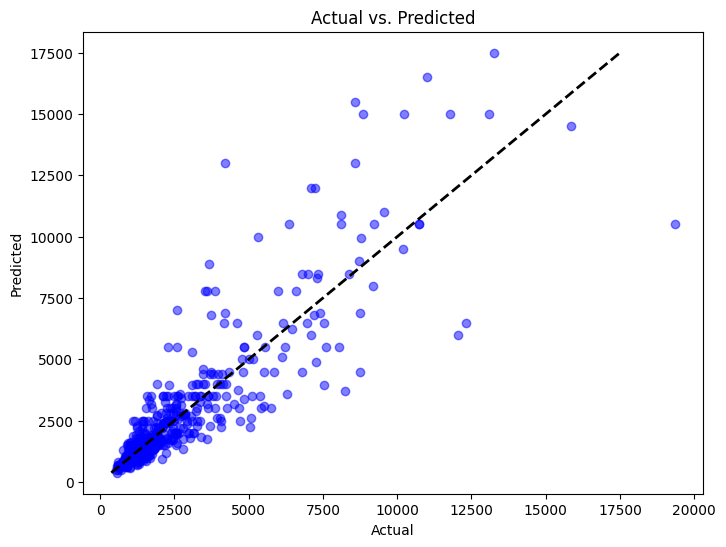

In [9]:
import matplotlib.pyplot as plt

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

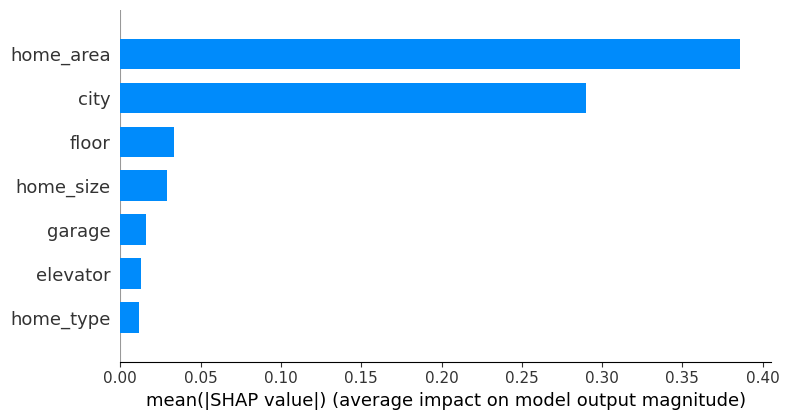

In [10]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)

shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

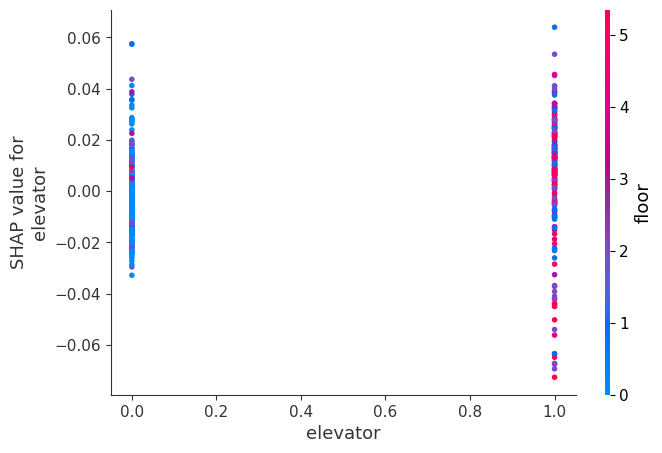

In [11]:
shap.dependence_plot("elevator", shap_values, X_test, interaction_index="floor")